In [2]:
import zipfile
import pandas as pd
import os
from google.colab import drive

# Step 1: Mount Google Drive
drive.mount('/content/drive')

# Step 2: Define path to ZIP file in your Google Drive
zip_path = '/content/drive/My Drive/sudoku.csv.zip'
extract_path = '/content/sudoku_data'  # where we'll extract the zip

# Step 3: Unzip the file
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 4: Find and read the extracted CSV
csv_file_path = os.path.join(extract_path, 'sudoku.csv')
sudoku_games = pd.read_csv(csv_file_path)

# Step 5: Display dataset info
print(f"\n✅ Dataset Info:")
print(f"Shape: {sudoku_games.shape}")
print(f"Columns: {sudoku_games.columns.tolist()}")
print(f"Memory usage: {sudoku_games.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Step 6: Show first few rows
print(f"\n🧩 First 5 rows:")
sudoku_games.head()

Mounted at /content/drive

✅ Dataset Info:
Shape: (9000000, 2)
Columns: ['puzzle', 'solution']
Memory usage: 2368.93 MB

🧩 First 5 rows:


,puzzle,solution
0,0700000430400096108006349000940520003584600200...,6795182435437296188216349577943521863584617292...
1,3010865040465210705000000014008000020803479000...,3719865248465213795924738614638197522853479167...
2,0483015603600080909106700030200009355090102006...,7483915623652487919126754834217869355894132766...
3,0083170000042051090000400703271609049014500000...,2983176457642851391539462783271689549814537266...
4,0408906300001368208007405190004670524500207002...,1428956379751368248367425193984671524513287962...


You want:
python# Sparse: digit 2 = [0,2,0,0,0,0,0,0,0,0]  # Put 2 at index 2
# Sparse: digit 4 = [0,0,0,0,4,0,0,0,0,0]  # Put 4 at index 4

for one msising element in one row


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

# Step 7: Process solutions into row dataset (limit to ~11k puzzles for 100k rows)
def create_row_dataset(sudoku_df, max_samples=100000):
    X, y = [], []
    samples_needed = max_samples // 9  # Each puzzle gives 9 rows

    for i, solution in enumerate(sudoku_df['solution']):
        if i >= samples_needed:
            break

        # Process each 9x9 grid row by row
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            input_row = [0] + row[1:]
            target = row[0]

            X.append(input_row)
            y.append(target)

    return np.array(X), np.array(y)

# Create dataset (100k samples)
X, y = create_row_dataset(sudoku_games, 100000)

# Convert to sparse encoding
X_sparse = np.zeros((len(X), 9, 10))
y_onehot = np.zeros((len(y), 9))

for i, row in enumerate(X):
    for j, num in enumerate(row):
        X_sparse[i, j, num] = num  # Put the digit value at its index position
    y_onehot[i, y[i]-1] = 1

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_onehot, test_size=0.2, random_state=42
)

print(f"✅ Dataset created: {len(X)} samples")

✅ Dataset created: 99999 samples


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Simple Neural Network Model
model_1 = models.Sequential([
   layers.Flatten(input_shape=(9, 10)),  # Flatten 9x10 to 90
   layers.Dense(128, activation='relu'),
   layers.Dense(64, activation='relu'),
   layers.Dense(9, activation='softmax')  # Output 9 classes (1-9)
])

# Compile
model_1.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

# Train
history = model_1.fit(
   X_train, y_train,
   epochs=10,
   batch_size=32,
   validation_data=(X_test, y_test),
   verbose=1
)

# Evaluate
test_loss, test_acc = model_1.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8158 - loss: 0.5730 - val_accuracy: 1.0000 - val_loss: 4.3726e-04
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 1.0000 - loss: 2.7167e-04 - val_accuracy: 1.0000 - val_loss: 5.9608e-05
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 1.0000 - loss: 4.1618e-05 - val_accuracy: 1.0000 - val_loss: 1.2275e-05
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 1.0000 - loss: 8.7120e-06 - val_accuracy: 1.0000 - val_loss: 2.8128e-06
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 1.0000 - loss: 2.0411e-06 - val_accuracy: 1.0000 - val_loss: 6.7478e-07
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 1.0000 - loss: 4.9026e-07 - val_accuracy: 1.0000 - val_loss: 1.5058e-07
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 1.0000 - loss: 1.0366e-07 - val_accuracy: 1.0000 - val_loss: 2.8425e-08
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━

In [5]:
# Test Block - See how model performs
import random

def test_model_predictions(model, X_test, y_test, num_samples=10):
   print("🧪 Testing Model Predictions:\n")

   # Get random test samples
   indices = random.sample(range(len(X_test)), num_samples)

   for i, idx in enumerate(indices):
       # Get input and true answer
       input_row = X_test[idx]
       true_answer = np.argmax(y_test[idx]) + 1  # Convert back to 1-9

       # Convert one-hot back to numbers for display
       display_row = []
       for pos in input_row:
           display_row.append(np.argmax(pos))

       # Make prediction
       prediction = model.predict(input_row.reshape(1, 9, 10), verbose=0)
       predicted_answer = np.argmax(prediction) + 1
       confidence = np.max(prediction) * 100

       # Display result
       print(f"Test {i+1}:")
       print(f"Input:     {display_row}")
       print(f"True:      {true_answer}")
       print(f"Predicted: {predicted_answer} (confidence: {confidence:.1f}%)")
       print(f"{'✅ CORRECT' if predicted_answer == true_answer else '❌ WRONG'}")
       print("-" * 40)

# Run test
test_model_predictions(model_1, X_test, y_test)

# Overall accuracy
predictions = model_1.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1) + 1
true_classes = np.argmax(y_test, axis=1) + 1
accuracy = np.mean(predicted_classes == true_classes)
print(f"\n🎯 Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

🧪 Testing Model Predictions:

Test 1:
Input:     [np.int64(0), np.int64(5), np.int64(2), np.int64(6), np.int64(9), np.int64(7), np.int64(3), np.int64(1), np.int64(4)]
True:      8
Predicted: 8 (confidence: 100.0%)
✅ CORRECT
----------------------------------------
Test 2:
Input:     [np.int64(0), np.int64(9), np.int64(8), np.int64(3), np.int64(6), np.int64(4), np.int64(7), np.int64(2), np.int64(1)]
True:      5
Predicted: 5 (confidence: 100.0%)
✅ CORRECT
----------------------------------------
Test 3:
Input:     [np.int64(0), np.int64(5), np.int64(9), np.int64(6), np.int64(7), np.int64(2), np.int64(3), np.int64(8), np.int64(1)]
True:      4
Predicted: 4 (confidence: 100.0%)
✅ CORRECT
----------------------------------------
Test 4:
Input:     [np.int64(0), np.int64(8), np.int64(4), np.int64(6), np.int64(5), np.int64(2), np.int64(3), np.int64(7), np.int64(1)]
True:      9
Predicted: 9 (confidence: 100.0%)
✅ CORRECT
----------------------------------------
Test 5:
Input:     [np.int64(0

for two missing number in 2 rows


In [6]:
# Step 8: Process data for 2 missing numbers per row
def create_2_missing_row_dataset(sudoku_df, max_samples=100000):
    X, y = [], []
    samples_needed = max_samples // 9

    for i, solution in enumerate(sudoku_df['solution']):
        if i >= samples_needed:
            break

        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]

            # Randomly choose 2 positions to make empty
            empty_positions = random.sample(range(9), 2)
            missing_numbers = [row[pos] for pos in empty_positions]

            # Create input with 2 zeros
            input_row = row.copy()
            for pos in empty_positions:
                input_row[pos] = 0

            X.append(input_row)
            y.append(missing_numbers)  # Now we have 2 targets

    return np.array(X), np.array(y)

# Create new dataset
X_2missing, y_2missing = create_2_missing_row_dataset(sudoku_games, 100000)

# Convert to sparse encoding
X_2missing_sparse = np.zeros((len(X_2missing), 9, 10))
y_2missing_onehot = np.zeros((len(y_2missing), 2, 9))  # 2 outputs, each 9 classes

for i, row in enumerate(X_2missing):
    for j, num in enumerate(row):
        X_2missing_sparse[i, j, num] = num  # Put digit value at its index position

    # Two targets
    for k, target in enumerate(y_2missing[i]):
        y_2missing_onehot[i, k, target-1] = 1

# Reshape y for model (flatten 2x9 to 18)
y_2missing_flat = y_2missing_onehot.reshape(len(y_2missing_onehot), 18)

# Train/test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2missing_sparse, y_2missing_flat, test_size=0.2, random_state=42
)

print(f"✅ 2-Missing Dataset: {len(X_2missing)} samples")
print(f"Input shape: {X_train_2.shape}")
print(f"Output shape: {y_train_2.shape}")  # Should be (samples, 18)

✅ 2-Missing Dataset: 99999 samples
Input shape: (79999, 9, 10)
Output shape: (79999, 18)


In [7]:
# New Model for 2 Missing Numbers
model_2missing = models.Sequential([
   layers.Input(shape=(9, 10)),
   layers.Flatten(),
   layers.Dense(256, activation='relu'),  # Bigger since more complex
   layers.Dropout(0.3),
   layers.Dense(128, activation='relu'),
   layers.Dropout(0.2),
   layers.Dense(64, activation='relu'),
   layers.Dense(18, activation='sigmoid')  # 18 outputs (2 numbers × 9 classes each)
])

# Compile with different loss for multi-output
model_2missing.compile(
   optimizer='adam',
   loss='binary_crossentropy',  # Better for multi-label
   metrics=['accuracy']
)

# Train
early_stop = tf.keras.callbacks.EarlyStopping(
   monitor='val_accuracy', patience=5, restore_best_weights=True
)

history_2 = model_2missing.fit(
   X_train_2, y_train_2,
   epochs=25,
   batch_size=64,
   validation_data=(X_test_2, y_test_2),
   callbacks=[early_stop],
   verbose=1
)

# Evaluate
test_loss, test_acc = model_2missing.evaluate(X_test_2, y_test_2, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.1735 - loss: 0.2877 - val_accuracy: 0.3139 - val_loss: 0.1587
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2496 - loss: 0.1617 - val_accuracy: 0.2896 - val_loss: 0.1559
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2509 - loss: 0.1574 - val_accuracy: 0.2178 - val_loss: 0.1551
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2524 - loss: 0.1563 - val_accuracy: 0.2385 - val_loss: 0.1553
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.2538 - loss: 0.1557 - val_accuracy: 0.2881 - val_loss: 0.1553
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.2565 - loss: 0.1555 - val_accuracy: 0.2401 - val_loss: 0.1548

✅ Test Accuracy: 0.3139


In [9]:
# Test Block for 2 Missing Numbers
def test_2missing_predictions(model, X_test, y_test, num_samples=10):
   print("🧪 Testing 2-Missing Model Predictions:\n")

   indices = random.sample(range(len(X_test)), num_samples)

   for i, idx in enumerate(indices):
       # Get input
       input_row = X_test[idx]

       # Convert one-hot back to numbers for display
       display_row = []
       empty_positions = []
       for pos, one_hot in enumerate(input_row):
           num = np.argmax(one_hot)
           display_row.append(num)
           if num == 0:
               empty_positions.append(pos)

       # Get true answers (reshape from flat 18 back to 2x9)
       true_answers_onehot = y_test[idx].reshape(2, 9)
       true_answers = [np.argmax(true_answers_onehot[0]) + 1,
                      np.argmax(true_answers_onehot[1]) + 1]

       # Make prediction
       prediction = model.predict(input_row.reshape(1, 9, 10), verbose=0)
       pred_reshaped = prediction.reshape(2, 9)

       predicted_answers = [np.argmax(pred_reshaped[0]) + 1,
                          np.argmax(pred_reshaped[1]) + 1]
       confidences = [np.max(pred_reshaped[0]) * 100,
                     np.max(pred_reshaped[1]) * 100]

       # Check if correct
       correct = set(predicted_answers) == set(true_answers)

       print(f"Test {i+1}:")
       print(f"Input:      {display_row}")
       print(f"Empty at:   positions {empty_positions}")
       print(f"True:       {sorted(true_answers)}")
       print(f"Predicted:  {sorted(predicted_answers)} (conf: {confidences[0]:.1f}%, {confidences[1]:.1f}%)")
       print(f"{'✅ CORRECT' if correct else '❌ WRONG'}")
       print("-" * 50)

# Run test
test_2missing_predictions(model_2missing, X_test_2, y_test_2)

# Overall accuracy (both numbers must be correct)
predictions = model_2missing.predict(X_test_2, verbose=0)
pred_reshaped = predictions.reshape(-1, 2, 9)
true_reshaped = y_test_2.reshape(-1, 2, 9)

correct_count = 0
for i in range(len(pred_reshaped)):
   pred_nums = [np.argmax(pred_reshaped[i][0]) + 1, np.argmax(pred_reshaped[i][1]) + 1]
   true_nums = [np.argmax(true_reshaped[i][0]) + 1, np.argmax(true_reshaped[i][1]) + 1]
   if set(pred_nums) == set(true_nums):
       correct_count += 1

accuracy = correct_count / len(pred_reshaped)
print(f"\n🎯 Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

🧪 Testing 2-Missing Model Predictions:

Test 1:
Input:      [np.int64(8), np.int64(7), np.int64(9), np.int64(0), np.int64(0), np.int64(3), np.int64(4), np.int64(6), np.int64(5)]
Empty at:   positions [3, 4]
True:       [np.int64(1), np.int64(2)]
Predicted:  [np.int64(1), np.int64(1)] (conf: 57.4%, 70.2%)
❌ WRONG
--------------------------------------------------
Test 2:
Input:      [np.int64(9), np.int64(8), np.int64(4), np.int64(6), np.int64(0), np.int64(0), np.int64(3), np.int64(7), np.int64(1)]
Empty at:   positions [4, 5]
True:       [np.int64(2), np.int64(5)]
Predicted:  [np.int64(5), np.int64(5)] (conf: 62.1%, 54.7%)
❌ WRONG
--------------------------------------------------
Test 3:
Input:      [np.int64(5), np.int64(6), np.int64(9), np.int64(0), np.int64(3), np.int64(8), np.int64(7), np.int64(0), np.int64(4)]
Empty at:   positions [3, 7]
True:       [np.int64(1), np.int64(2)]
Predicted:  [np.int64(1), np.int64(2)] (conf: 55.3%, 67.7%)
✅ CORRECT
----------------------------------

✅ Goal
For each sample:

Input = 2 Sudoku rows (each with 1 digit missing, i.e., [0, d2, ..., d9])

Target = the missing digit of the first row

In [10]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

def create_two_row_dataset(sudoku_df, max_samples=100000):
    X, y = [], []
    samples_needed = max_samples // 36  # Each puzzle generates 36 samples (9 rows × 4 pairs each)

    for i, solution in enumerate(sudoku_df['solution']):
        if i >= samples_needed:
            break

        # Convert solution to 9x9 grid
        rows = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            rows.append(row)

        # Create pairs from consecutive rows
        for j in range(8):  # rows 0-1, 1-2, ..., 7-8
            row1 = rows[j].copy()
            row2 = rows[j + 1].copy()

            # Generate multiple samples per row pair
            for _ in range(4):  # 4 samples per pair
                # Hide random positions
                pos1 = random.randint(0, 8)
                pos2 = random.randint(0, 8)

                # Store original values
                missing1 = row1[pos1]
                missing2 = row2[pos2]

                # Create input with hidden digits
                input_row1 = row1.copy()
                input_row2 = row2.copy()
                input_row1[pos1] = 0
                input_row2[pos2] = 0

                # Combine both rows (18 elements)
                combined_input = input_row1 + input_row2

                # Target: both missing digits
                target = [missing1, missing2]

                X.append(combined_input)
                y.append(target)

    return np.array(X), np.array(y)

# Create dataset
print("🔄 Creating two-row dataset...")
X, y = create_two_row_dataset(sudoku_games, max_samples=50000)
print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Sparse encode inputs (18 positions, 10 classes each: 0-9)
X_sparse = np.zeros((len(X), 18, 10))
for i, row in enumerate(X):
    for j, num in enumerate(row):
        X_sparse[i, j, num] = num  # Put digit value at its index position

# One-hot encode targets (2 digits, 9 classes each: 1-9)
y_onehot = np.zeros((len(y), 2, 9))
for i, targets in enumerate(y):
    y_onehot[i, 0, targets[0] - 1] = 1  # First missing digit (1-9 → 0-8)
    y_onehot[i, 1, targets[1] - 1] = 1  # Second missing digit (1-9 → 0-8)

# Reshape y for model training (flatten to 18 outputs)
y_flat = y_onehot.reshape(len(y_onehot), 18)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_flat, test_size=0.2, random_state=42
)

print(f"✅ Training data: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test data: X={X_test.shape}, y={y_test.shape}")
print(f"Sample input shape: {X_train[0].shape}")
print(f"Sample target shape: {y_train[0].shape}")

🔄 Creating two-row dataset...
Dataset shape: X=(44416, 18), y=(44416, 2)
✅ Training data: X=(35532, 18, 10), y=(35532, 18)
✅ Test data: X=(8884, 18, 10), y=(8884, 18)
Sample input shape: (18, 10)
Sample target shape: (18,)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Neural Network for Two Sudoku Rows (predicts 2 missing digits)
model_3 = models.Sequential([
    layers.Input(shape=(18, 10)),           # Input: 2 rows × 9 digits (each one-hot of size 10)
    layers.Flatten(),                       # Flatten 18x10 = 180 features
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(18, activation='sigmoid')  # Output: 18 values (2 rows × 9 digits each)
])

# Compile the model
model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Changed from categorical_crossentropy
    metrics=['accuracy']
)

# Early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train the model
print("🚀 Training model...")
history = model_3.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Evaluate model performance
test_loss, test_acc = model_3.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")

print("\n📊 Model Summary:")
model_3.summary()

🚀 Training model...
Epoch 1/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1498 - loss: 0.3605 - val_accuracy: 0.5024 - val_loss: 0.0876
Epoch 2/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4841 - loss: 0.0901 - val_accuracy: 0.4657 - val_loss: 0.0091
Epoch 3/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4909 - loss: 0.0170 - val_accuracy: 0.4991 - val_loss: 3.9676e-04
Epoch 4/20
556/556 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4899 - loss: 0.0052 - val_accuracy: 0.4737 - val_loss: 7.4514e-05

✅ Test Accuracy: 0.5024

📊 Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 180)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        46,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 18)             │         2,322 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,664 (955.72 KB)

 Trainable params: 81,554 (318.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 163,110 (637.15 KB)

In [13]:
# Test Block - See dual predictions
import random
import numpy as np

def test_dual_predictions(model, X_test, y_test, num_samples=10):
    print("🧪 Testing Dual Prediction Model:\n")

    indices = random.sample(range(len(X_test)), num_samples)

    for i, idx in enumerate(indices):
        # Get input and true answers
        input_rows = X_test[idx]  # Shape: (18, 10)
        true_targets = y_test[idx]  # Shape: (18,) - flattened

        # Reshape true targets back to (2, 9)
        true_reshaped = true_targets.reshape(2, 9)
        true_digit1 = np.argmax(true_reshaped[0]) + 1  # First row missing digit
        true_digit2 = np.argmax(true_reshaped[1]) + 1  # Second row missing digit

        # Convert input back to display format
        row1 = [np.argmax(input_rows[j]) for j in range(9)]
        row2 = [np.argmax(input_rows[j]) for j in range(9, 18)]

        # Find missing positions (where digit is 0)
        missing_pos1 = row1.index(0) if 0 in row1 else -1
        missing_pos2 = row2.index(0) if 0 in row2 else -1

        # Make prediction
        prediction = model.predict(input_rows.reshape(1, 18, 10), verbose=0)
        pred_reshaped = prediction.reshape(2, 9)

        # Get predicted digits
        pred_digit1 = np.argmax(pred_reshaped[0]) + 1
        pred_digit2 = np.argmax(pred_reshaped[1]) + 1

        # Get confidence scores
        conf1 = np.max(pred_reshaped[0]) * 100
        conf2 = np.max(pred_reshaped[1]) * 100

        # Display results
        print(f"Test {i+1}:")
        print(f"Row 1:     {row1} (missing pos {missing_pos1})")
        print(f"Row 2:     {row2} (missing pos {missing_pos2})")
        print(f"True:      [{true_digit1}, {true_digit2}]")
        print(f"Predicted: [{pred_digit1}, {pred_digit2}]")
        print(f"Confidence: [{conf1:.1f}%, {conf2:.1f}%]")

        # Check correctness
        correct1 = pred_digit1 == true_digit1
        correct2 = pred_digit2 == true_digit2
        both_correct = correct1 and correct2

        print(f"Row 1: {'✅' if correct1 else '❌'} | Row 2: {'✅' if correct2 else '❌'} | Both: {'✅' if both_correct else '❌'}")
        print("-" * 50)

# Run test
test_dual_predictions(model_3, X_test, y_test)

# Overall accuracy for dual predictions
print("\n🎯 Overall Accuracy Analysis:")
predictions = model_3.predict(X_test, verbose=0)
pred_reshaped = predictions.reshape(-1, 2, 9)
true_reshaped = y_test.reshape(-1, 2, 9)

# Individual row accuracies
row1_pred = np.argmax(pred_reshaped[:, 0, :], axis=1) + 1
row1_true = np.argmax(true_reshaped[:, 0, :], axis=1) + 1
row1_acc = np.mean(row1_pred == row1_true)

row2_pred = np.argmax(pred_reshaped[:, 1, :], axis=1) + 1
row2_true = np.argmax(true_reshaped[:, 1, :], axis=1) + 1
row2_acc = np.mean(row2_pred == row2_true)

# Both correct accuracy
both_correct = (row1_pred == row1_true) & (row2_pred == row2_true)
both_acc = np.mean(both_correct)

print(f"Row 1 Accuracy: {row1_acc:.4f} ({row1_acc*100:.2f}%)")
print(f"Row 2 Accuracy: {row2_acc:.4f} ({row2_acc*100:.2f}%)")
print(f"Both Correct:   {both_acc:.4f} ({both_acc*100:.2f}%)")
print(f"Average:        {(row1_acc + row2_acc)/2:.4f} ({(row1_acc + row2_acc)*50:.2f}%)")

🧪 Testing Dual Prediction Model:

Test 1:
Row 1:     [np.int64(9), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(0), np.int64(6), np.int64(8), np.int64(3)] (missing pos 5)
Row 2:     [np.int64(7), np.int64(3), np.int64(0), np.int64(6), np.int64(8), np.int64(1), np.int64(9), np.int64(2), np.int64(5)] (missing pos 2)
True:      [7, 4]
Predicted: [7, 4]
Confidence: [98.7%, 60.0%]
Row 1: ✅ | Row 2: ✅ | Both: ✅
--------------------------------------------------
Test 2:
Row 1:     [np.int64(7), np.int64(6), np.int64(2), np.int64(9), np.int64(1), np.int64(8), np.int64(5), np.int64(0), np.int64(4)] (missing pos 7)
Row 2:     [np.int64(1), np.int64(4), np.int64(0), np.int64(5), np.int64(6), np.int64(7), np.int64(9), np.int64(8), np.int64(2)] (missing pos 2)
True:      [3, 3]
Predicted: [3, 3]
Confidence: [21.9%, 62.4%]
Row 1: ✅ | Row 2: ✅ | Both: ✅
--------------------------------------------------
Test 3:
Row 1:     [np.int64(5), np.int64(8), np.int64(0), np.int64(1), np.int64(2

here is one row and one column combind like a L shape and of those total 17 numbers one is misisng

In [14]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

def create_l_shape_dataset(sudoku_df, max_samples=100000):
    X, y = [], []
    samples_needed = max_samples // 81  # Each puzzle generates 81 samples (9x9 possible L-shapes)

    for i, solution in enumerate(sudoku_df['solution']):
        if i >= samples_needed:
            break

        # Convert solution to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Generate L-shapes for each position in the grid
        for row_idx in range(9):
            for col_idx in range(9):
                # Get the complete row
                row_data = grid[row_idx].copy()

                # Get the complete column
                col_data = [grid[r][col_idx] for r in range(9)]

                # Create L-shape: row + column (intersection counted once)
                # Row: positions 0-8, Column: positions 9-16 (skip intersection at row_idx)
                l_shape = row_data + col_data[:row_idx] + col_data[row_idx+1:]
                # Result: 9 (row) + 8 (column excluding intersection) = 17 elements

                # Choose random position to hide (0-16)
                missing_pos = random.randint(0, 16)
                missing_digit = l_shape[missing_pos]

                # Create input with missing digit
                input_l = l_shape.copy()
                input_l[missing_pos] = 0

                X.append(input_l)
                y.append(missing_digit)

    return np.array(X), np.array(y)

# Create dataset
print("🔄 Creating L-shape dataset...")
X, y = create_l_shape_dataset(sudoku_games, max_samples=50000)
print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Sparse encode inputs (17 positions, 10 classes each: 0-9)
X_sparse = np.zeros((len(X), 17, 10))
for i, l_shape in enumerate(X):
    for j, num in enumerate(l_shape):
        X_sparse[i, j, num] = num  # Put digit value at its index position

# One-hot encode targets (9 classes: 1-9)
y_onehot = np.zeros((len(y), 9))
for i, target in enumerate(y):
    y_onehot[i, target - 1] = 1  # Map 1-9 to indices 0-8

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_onehot, test_size=0.2, random_state=42
)

print(f"✅ Training data: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test data: X={X_test.shape}, y={y_test.shape}")
print(f"Sample input shape: {X_train[0].shape}")  # Should be (17, 10)
print(f"Sample target shape: {y_train[0].shape}")  # Should be (9,)

🔄 Creating L-shape dataset...
Dataset shape: X=(49977, 17), y=(49977,)
✅ Training data: X=(39981, 17, 10), y=(39981, 9)
✅ Test data: X=(9996, 17, 10), y=(9996, 9)
Sample input shape: (17, 10)
Sample target shape: (9,)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Build L-Shape Model
model_4 = Sequential([
    # Input: (17, 10) sparse encoded L-shape
    Flatten(input_shape=(17, 10)),  # Flatten to 170 features

    # Hidden layers
    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(64, activation='relu'),

    # Output: 9 classes (digits 1-9)
    Dense(9, activation='softmax')
])

# Compile model
model_4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("🏗️ L-Shape Model Architecture:")
model_4.summary()

# Train model
print("\n🚀 Training L-Shape Model...")
history = model_4.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=256,
    verbose=1
)

# Evaluate
print("\n📊 Final Evaluation:")
loss, accuracy = model_4.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Save model
model_4.save('l_shape_sudoku_model.h5')
print("✅ Model saved as 'l_shape_sudoku_model.h5'")

🏗️ L-Shape Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 170)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        43,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,513 (334.04 KB)

 Trainable params: 85,513 (334.04 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training L-Shape Model...
Epoch 1/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.1291 - loss: 2.2779 - val_accuracy: 0.2703 - val_loss: 2.0546
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2900 - loss: 1.9333 - val_accuracy: 0.5408 - val_loss: 1.2621
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5078 - loss: 1.3417 - val_accuracy: 0.6133 - val_loss: 0.9672
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6076 - loss: 1.0436 - val_accuracy: 0.6622 - val_loss: 0.7695
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6750 - loss: 0.8291 - val_accuracy: 0.7039 - val_loss: 0.6399
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7167 - loss: 0.6847 - val_accuracy: 0.7317 - val_loss: 0.5342
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7527 - loss: 0.5761 - val_accuracy: 0.7494 - val_loss: 0.4614
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7800 - l

Test Accuracy: 0.7646 (76.46%)
✅ Model saved as 'l_shape_sudoku_model.h5'


In [18]:
import numpy as np
import random

def test_l_shape_model(model, sudoku_df, num_tests=10):
    print("🧪 Testing L-Shape Model Predictions:\n")

    correct_predictions = 0

    for test_num in range(num_tests):
        # Pick random puzzle
        puzzle_idx = random.randint(0, len(sudoku_df) - 1)
        solution = sudoku_df.iloc[puzzle_idx]['solution']

        # Convert to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Pick random L-shape position
        row_idx = random.randint(0, 8)
        col_idx = random.randint(0, 8)

        # Create L-shape
        row_data = grid[row_idx].copy()
        col_data = [grid[r][col_idx] for r in range(9)]
        l_shape = row_data + col_data[:row_idx] + col_data[row_idx+1:]

        # Pick random position to hide
        missing_pos = random.randint(0, 16)
        true_digit = l_shape[missing_pos]

        # Create test input
        test_input = l_shape.copy()
        test_input[missing_pos] = 0

        # Sparse encode
        X_test_sparse = np.zeros((1, 17, 10))
        for j, num in enumerate(test_input):
            X_test_sparse[0, j, num] = num

        # Predict
        prediction = model.predict(X_test_sparse, verbose=0)
        predicted_digit = np.argmax(prediction[0]) + 1  # Convert back to 1-9
        confidence = np.max(prediction[0]) * 100

        # Check correctness
        is_correct = predicted_digit == true_digit
        if is_correct:
            correct_predictions += 1

        # Display results
        print(f"Test {test_num + 1}:")
        print(f"L-Shape Row {row_idx}, Col {col_idx} (missing pos {missing_pos})")

        # Show L-shape with missing position marked
        display_l = test_input.copy()
        display_l[missing_pos] = 0

        print(f"Row part:    {display_l[:9]}")
        print(f"Column part: {display_l[9:]}")
        print(f"True:        {true_digit}")
        print(f"Predicted:   {predicted_digit} (confidence: {confidence:.1f}%)")
        print(f"Result:      {'✅ CORRECT' if is_correct else '❌ WRONG'}")
        print("-" * 50)

    # Overall accuracy
    accuracy = correct_predictions / num_tests
    print(f"\n🎯 Overall Test Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    return accuracy

# Run tests
test_accuracy = test_l_shape_model(model_4, sudoku_games, num_tests=10)

🧪 Testing L-Shape Model Predictions:

Test 1:
L-Shape Row 1, Col 4 (missing pos 4)
Row part:    [2, 4, 5, 9, 0, 3, 6, 7, 1]
Column part: [7, 6, 5, 3, 4, 2, 1, 9]
True:        8
Predicted:   8 (confidence: 100.0%)
Result:      ✅ CORRECT
--------------------------------------------------
Test 2:
L-Shape Row 0, Col 6 (missing pos 14)
Row part:    [7, 8, 5, 9, 2, 3, 4, 6, 1]
Column part: [2, 5, 3, 7, 8, 0, 9, 1]
True:        6
Predicted:   4 (confidence: 70.1%)
Result:      ❌ WRONG
--------------------------------------------------
Test 3:
L-Shape Row 8, Col 1 (missing pos 13)
Row part:    [8, 3, 6, 7, 2, 4, 5, 9, 1]
Column part: [6, 1, 8, 2, 0, 5, 7, 4]
True:        9
Predicted:   9 (confidence: 54.4%)
Result:      ✅ CORRECT
--------------------------------------------------
Test 4:
L-Shape Row 6, Col 0 (missing pos 5)
Row part:    [3, 4, 8, 2, 1, 0, 5, 7, 6]
Column part: [7, 8, 2, 4, 9, 6, 5, 1]
True:        9
Predicted:   9 (confidence: 100.0%)
Result:      ✅ CORRECT
-------------------

now common row and column sleeemnts misisng
\

In [19]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

def create_l_shape_intersection_dataset(sudoku_df, max_samples=100000):
    X, y = [], []
    samples_needed = max_samples // 81  # Each puzzle generates 81 samples (9x9 positions)

    for i, solution in enumerate(sudoku_df['solution']):
        if i >= samples_needed:
            break

        # Convert solution to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Generate L-shapes for each intersection position
        for row_idx in range(9):
            for col_idx in range(9):
                # Get the intersection digit (this will be our target)
                intersection_digit = grid[row_idx][col_idx]

                # Get row data with intersection missing
                row_data = grid[row_idx].copy()
                row_data[col_idx] = 0  # Hide intersection in row

                # Get column data with intersection missing
                col_data = [grid[r][col_idx] for r in range(9)]
                col_data[row_idx] = 0  # Hide intersection in column

                # Create L-shape: row + column (both missing intersection)
                # Remove intersection from column part to avoid duplication
                l_shape = row_data + col_data[:row_idx] + col_data[row_idx+1:]
                # Result: 9 (row with 0 at intersection) + 8 (column excluding intersection) = 17 elements

                X.append(l_shape)
                y.append(intersection_digit)

    return np.array(X), np.array(y)

# Create dataset
print("🔄 Creating L-shape intersection dataset...")
X, y = create_l_shape_intersection_dataset(sudoku_games, max_samples=50000)
print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Sparse encode inputs (17 positions, 10 classes each: 0-9)
X_sparse = np.zeros((len(X), 17, 10))
for i, l_shape in enumerate(X):
    for j, num in enumerate(l_shape):
        X_sparse[i, j, num] = num  # Put digit value at its index position

# One-hot encode targets (9 classes: 1-9)
y_onehot = np.zeros((len(y), 9))
for i, target in enumerate(y):
    y_onehot[i, target - 1] = 1  # Map 1-9 to indices 0-8

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_onehot, test_size=0.2, random_state=42
)

print(f"✅ Training data: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test data: X={X_test.shape}, y={y_test.shape}")
print(f"Sample input shape: {X_train[0].shape}")  # Should be (17, 10)
print(f"Sample target shape: {y_train[0].shape}")  # Should be (9,)
print(f"✅ Dataset ready - Missing intersection digit task!")

🔄 Creating L-shape intersection dataset...
Dataset shape: X=(49977, 17), y=(49977,)
✅ Training data: X=(39981, 17, 10), y=(39981, 9)
✅ Test data: X=(9996, 17, 10), y=(9996, 9)
Sample input shape: (17, 10)
Sample target shape: (9,)
✅ Dataset ready - Missing intersection digit task!


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Build L-Shape Intersection Model
model_5 = Sequential([
    # Input: (17, 10) sparse encoded L-shape
    Flatten(input_shape=(17, 10)),  # Flatten to 170 features

    # Hidden layers - slightly deeper for intersection reasoning
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, activation='relu'),
    Dropout(0.2),

    Dense(64, activation='relu'),

    # Output: 9 classes (digits 1-9)
    Dense(9, activation='softmax')
])

# Compile model
model_5.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
print("🏗️ L-Shape Intersection Model Architecture:")
model_5.summary()

# Train model
print("\n🚀 Training L-Shape Intersection Model...")
history = model_5.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=256,
    verbose=1
)

# Evaluate
print("\n📊 Final Evaluation:")
loss, accuracy = model_5.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Save model
model_5.save('l_shape_intersection_model.h5')
print("✅ Model saved as 'l_shape_intersection_model.h5'")

🏗️ L-Shape Intersection Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 170)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 512)            │        87,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,689 (1.01 MB)

 Trainable params: 262,153 (1.00 MB)

 Non-trainable params: 1,536 (6.00 KB)


🚀 Training L-Shape Intersection Model...
Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.4140 - loss: 1.6291 - val_accuracy: 0.8570 - val_loss: 0.3560
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9775 - loss: 0.0684 - val_accuracy: 1.0000 - val_loss: 2.0393e-04
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9969 - loss: 0.0093 - val_accuracy: 1.0000 - val_loss: 2.3965e-05
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9985 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 7.6728e-06
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9991 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 1.4927e-06
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9994 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.7181e-06
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 7.6718e-07
Epoch 8/20
157/157 ━━━━━━━━━━━━━━━━━

Test Accuracy: 1.0000 (100.00%)
✅ Model saved as 'l_shape_intersection_model.h5'


In [22]:
import numpy as np
import random

def test_l_shape_intersection_model(model, sudoku_df, num_tests=10):
    print("🧪 Testing L-Shape Intersection Model:\n")

    correct_predictions = 0

    for test_num in range(num_tests):
        # Pick random puzzle
        puzzle_idx = random.randint(0, len(sudoku_df) - 1)
        solution = sudoku_df.iloc[puzzle_idx]['solution']

        # Convert to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Pick random intersection position
        row_idx = random.randint(0, 8)
        col_idx = random.randint(0, 8)

        # The intersection digit is our target
        true_digit = grid[row_idx][col_idx]

        # Create L-shape with intersection missing
        row_data = grid[row_idx].copy()
        row_data[col_idx] = 0  # Hide intersection in row

        col_data = [grid[r][col_idx] for r in range(9)]
        col_data[row_idx] = 0  # Hide intersection in column

        # Build L-shape input
        l_shape = row_data + col_data[:row_idx] + col_data[row_idx+1:]

        # Sparse encode
        X_test_sparse = np.zeros((1, 17, 10))
        for j, num in enumerate(l_shape):
            X_test_sparse[0, j, num] = num

        # Predict
        prediction = model.predict(X_test_sparse, verbose=0)
        predicted_digit = np.argmax(prediction[0]) + 1  # Convert back to 1-9
        confidence = np.max(prediction[0]) * 100

        # Check correctness
        is_correct = predicted_digit == true_digit
        if is_correct:
            correct_predictions += 1

        # Display results
        print(f"Test {test_num + 1}:")
        print(f"Intersection at Row {row_idx}, Col {col_idx}")

        # Show row and column with missing intersection (marked as 0)
        display_row = row_data.copy()
        display_col = [grid[r][col_idx] if r != row_idx else 0 for r in range(9)]

        print(f"Row {row_idx}:     {display_row} (missing at pos {col_idx})")
        print(f"Col {col_idx}:     {display_col} (missing at pos {row_idx})")
        print(f"True intersection:    {true_digit}")
        print(f"Predicted:           {predicted_digit} (confidence: {confidence:.1f}%)")
        print(f"Result:              {'✅ CORRECT' if is_correct else '❌ WRONG'}")
        print("-" * 55)

    # Overall accuracy
    accuracy = correct_predictions / num_tests
    print(f"\n🎯 Overall Intersection Accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
    return accuracy

# Run tests
test_accuracy = test_l_shape_intersection_model(model_5, sudoku_games, num_tests=10)

🧪 Testing L-Shape Intersection Model:

Test 1:
Intersection at Row 3, Col 8
Row 3:     [6, 1, 2, 8, 5, 9, 7, 4, 0] (missing at pos 8)
Col 8:     [8, 2, 6, 0, 1, 5, 7, 4, 9] (missing at pos 3)
True intersection:    3
Predicted:           3 (confidence: 100.0%)
Result:              ✅ CORRECT
-------------------------------------------------------
Test 2:
Intersection at Row 5, Col 6
Row 5:     [7, 3, 5, 2, 4, 6, 0, 1, 8] (missing at pos 6)
Col 6:     [6, 7, 5, 2, 4, 0, 1, 3, 8] (missing at pos 5)
True intersection:    9
Predicted:           9 (confidence: 100.0%)
Result:              ✅ CORRECT
-------------------------------------------------------
Test 3:
Intersection at Row 5, Col 4
Row 5:     [7, 5, 6, 4, 0, 1, 8, 9, 3] (missing at pos 4)
Col 4:     [8, 1, 7, 5, 6, 0, 3, 9, 4] (missing at pos 5)
True intersection:    2
Predicted:           2 (confidence: 100.0%)
Result:              ✅ CORRECT
-------------------------------------------------------
Test 4:
Intersection at Row 7, Col 4


ow common row and column sleeemnts misisngand plus one element from one row and oen element from one columns whidhc totls us to total 3 leemtns missing

In [23]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

def create_triple_missing_dataset(sudoku_df, max_samples=100000):
    X, y = [], []
    samples_needed = max_samples // 81

    for i, solution in enumerate(sudoku_df['solution']):
        if i >= samples_needed:
            break

        # Convert to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Generate samples for each intersection
        for row_idx in range(9):
            for col_idx in range(9):
                # Target: intersection digit
                intersection_digit = grid[row_idx][col_idx]

                # Create row with 2 missing (intersection + 1 random)
                row_data = grid[row_idx].copy()
                row_data[col_idx] = 0  # Hide intersection
                row_missing_pos = random.choice([j for j in range(9) if j != col_idx])
                row_data[row_missing_pos] = 0  # Hide additional element

                # Create column with 2 missing (intersection + 1 random)
                col_data = [grid[r][col_idx] for r in range(9)]
                col_data[row_idx] = 0  # Hide intersection
                col_missing_pos = random.choice([j for j in range(9) if j != row_idx])
                col_data[col_missing_pos] = 0  # Hide additional element

                # L-shape: row + column (excluding shared intersection)
                l_shape = row_data + col_data[:row_idx] + col_data[row_idx+1:]
                # Result: 9 (row) + 8 (column excluding intersection) = 17 positions

                X.append(l_shape)
                y.append(intersection_digit)

    return np.array(X), np.array(y)

# Create dataset
print("🔄 Creating triple-missing L-shape dataset...")
X, y = create_triple_missing_dataset(sudoku_games, max_samples=50000)
print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Sparse encode inputs (17 positions, 10 classes each: 0-9)
X_sparse = np.zeros((len(X), 17, 10))
for i, sample in enumerate(X):
    for j, num in enumerate(sample):
        X_sparse[i, j, num] = 1

# One-hot encode targets
y_onehot = np.zeros((len(y), 9))
for i, target in enumerate(y):
    y_onehot[i, target - 1] = 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_onehot, test_size=0.2, random_state=42
)

print(f"✅ Training: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test: X={X_test.shape}, y={y_test.shape}")
print(f"✅ Triple-missing L-shape (17 positions) ready!")

🔄 Creating triple-missing L-shape dataset...
Dataset shape: X=(49977, 17), y=(49977,)
✅ Training: X=(39981, 17, 10), y=(39981, 9)
✅ Test: X=(9996, 17, 10), y=(9996, 9)
✅ Triple-missing L-shape (17 positions) ready!


In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_triple_missing_model():
   model_6 = models.Sequential([
       # Input: (17, 10) - 17 positions with 10-class encoding
       layers.Input(shape=(17, 10)),

       # Flatten the input
       layers.Flatten(),  # (17*10 = 170,)

       # Dense layers
       layers.Dense(128, activation='relu'),
       layers.Dropout(0.3),
       layers.Dense(64, activation='relu'),
       layers.Dropout(0.2),

       # Output: 9 classes (digits 1-9)
       layers.Dense(9, activation='softmax')
   ])

   return model_6

# Create and compile model
model_6 = create_triple_missing_model()
model_6.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy']
)

# Model summary
model_6.summary()

# Train model
print("🔄 Training model...")
history = model_6.fit(
   X_train, y_train,
   batch_size=32,
   epochs=20,
   validation_data=(X_test, y_test),
   verbose=1
)

# Evaluate
test_loss, test_acc = model_6.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_10 (Flatten)            │ (None, 170)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        21,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,729 (120.04 KB)

 Trainable params: 30,729 (120.04 KB)

 Non-trainable params: 0 (0.00 B)

🔄 Training model...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.4297 - loss: 1.5306 - val_accuracy: 0.9383 - val_loss: 0.1369
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9152 - loss: 0.2517 - val_accuracy: 0.9378 - val_loss: 0.1244
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9308 - loss: 0.1953 - val_accuracy: 0.9367 - val_loss: 0.1241
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9408 - loss: 0.1691 - val_accuracy: 0.9369 - val_loss: 0.1214
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9441 - loss: 0.1522 - val_accuracy: 0.9387 - val_loss: 0.1173
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9460 - loss: 0.1359 - val_accuracy: 0.9384 - val_loss: 0.1081
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9493 - loss: 0.1223 - val_accuracy: 0.9363 - val_loss: 0.1107
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.94

In [26]:
# Test block - Predict all 3 missing numbers
import numpy as np

def test_predict_3_missing(model, sudoku_df, num_cases=10):
    """Test model by predicting all 3 missing numbers in L-shape"""

    print("🎯 Testing Model - Predict 3 Missing Numbers")
    print("=" * 60)

    for case_num in range(num_cases):
        print(f"\nTest Case {case_num + 1}:")
        print("-" * 30)

        # Get random sudoku solution
        solution = sudoku_df['solution'].iloc[case_num]

        # Convert to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Pick random intersection
        row_idx = np.random.randint(0, 9)
        col_idx = np.random.randint(0, 9)

        # Get the 3 missing positions
        intersection_digit = grid[row_idx][col_idx]

        # Pick random missing from row (not intersection)
        row_missing_pos = np.random.choice([j for j in range(9) if j != col_idx])
        row_missing_digit = grid[row_idx][row_missing_pos]

        # Pick random missing from column (not intersection)
        col_missing_pos = np.random.choice([j for j in range(9) if j != row_idx])
        col_missing_digit = grid[col_missing_pos][col_idx]

        print(f"Position: Row {row_idx}, Col {col_idx}")
        print(f"Missing from row pos {row_missing_pos}")
        print(f"Missing from col pos {col_missing_pos}")

        # Create L-shape with 3 missing
        row_data = grid[row_idx].copy()
        row_data[col_idx] = 0  # Hide intersection
        row_data[row_missing_pos] = 0  # Hide random from row

        col_data = [grid[r][col_idx] for r in range(9)]
        col_data[row_idx] = 0  # Hide intersection
        col_data[col_missing_pos] = 0  # Hide random from column

        # Create L-shape (17 positions)
        l_shape = row_data + col_data[:row_idx] + col_data[row_idx+1:]

        print(f"Row with 2 missing:    {row_data}")
        print(f"Column with 2 missing: {col_data}")

        # Convert to model input format
        X_input = np.zeros((1, 17, 10))
        for j, num in enumerate(l_shape):
            X_input[0, j, num] = 1

        # Predict intersection
        prediction = model.predict(X_input, verbose=0)
        predicted_intersection = np.argmax(prediction) + 1
        confidence = np.max(prediction) * 100

        # Show results
        print("\n🎯 PREDICTIONS:")
        print(f"Intersection (True: {intersection_digit}) → Predicted: {predicted_intersection} ({confidence:.1f}%)")

        # For row missing - find what's missing from row
        row_known = [x for x in row_data if x != 0]
        row_candidates = [x for x in range(1, 10) if x not in row_known]
        print(f"Row missing (True: {row_missing_digit}) → Candidates: {row_candidates}")

        # For column missing - find what's missing from column
        col_known = [x for x in col_data if x != 0]
        col_candidates = [x for x in range(1, 10) if x not in col_known]
        print(f"Column missing (True: {col_missing_digit}) → Candidates: {col_candidates}")

        # Check intersection prediction
        if predicted_intersection == intersection_digit:
            print("✅ Intersection CORRECT")
        else:
            print("❌ Intersection WRONG")

        # Check if other candidates include true values
        row_correct = row_missing_digit in row_candidates
        col_correct = col_missing_digit in col_candidates

        print(f"Row candidate correct: {'✅' if row_correct else '❌'}")
        print(f"Col candidate correct: {'✅' if col_correct else '❌'}")

        print(f"Overall: {3 if (predicted_intersection == intersection_digit and row_correct and col_correct) else 'Some wrong'}/3 correct")

# Run the test
test_predict_3_missing(model_6, sudoku_games, num_cases=10)

🎯 Testing Model - Predict 3 Missing Numbers

Test Case 1:
------------------------------
Position: Row 3, Col 8
Missing from row pos 4
Missing from col pos 5
Row with 2 missing:    [7, 9, 4, 3, 0, 2, 1, 8, 0]
Column with 2 missing: [3, 8, 7, 0, 9, 0, 1, 5, 2]

🎯 PREDICTIONS:
Intersection (True: 6) → Predicted: 6 (99.9%)
Row missing (True: 5) → Candidates: [5, 6]
Column missing (True: 4) → Candidates: [4, 6]
✅ Intersection CORRECT
Row candidate correct: ✅
Col candidate correct: ✅
Overall: 3/3 correct

Test Case 2:
------------------------------
Position: Row 1, Col 1
Missing from row pos 2
Missing from col pos 6
Row with 2 missing:    [8, 0, 0, 5, 2, 1, 3, 7, 9]
Column with 2 missing: [7, 0, 9, 6, 8, 1, 0, 2, 5]

🎯 PREDICTIONS:
Intersection (True: 4) → Predicted: 4 (99.9%)
Row missing (True: 6) → Candidates: [4, 6]
Column missing (True: 3) → Candidates: [3, 4]
✅ Intersection CORRECT
Row candidate correct: ✅
Col candidate correct: ✅
Overall: 3/3 correct

Test Case 3:
--------------------

This creates a dataset where:

2 rows: Current row (missing intersection) + random row (missing 1 element)
2 columns: Current column (missing intersection) + random column (missing 1 element)
Total: 36 positions (9+9+9+9)
Target: The intersection digit from the original position

Each sample has exactly 4 missing elements total across the 2 rows and 2 columns

In [27]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

def create_2rows_2cols_dataset(sudoku_df, max_samples=100000):
    X, y = [], []
    samples_needed = max_samples // 81

    for i, solution in enumerate(sudoku_df['solution']):
        if i >= samples_needed:
            break

        # Convert to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Generate samples for each intersection
        for row_idx in range(9):
            for col_idx in range(9):
                # Target: intersection digit
                intersection_digit = grid[row_idx][col_idx]

                # Select 2 rows: current row + 1 random row
                other_row = random.choice([r for r in range(9) if r != row_idx])

                # Select 2 columns: current column + 1 random column
                other_col = random.choice([c for c in range(9) if c != col_idx])

                # Create row1 with 1 missing (hide intersection)
                row1_data = grid[row_idx].copy()
                row1_data[col_idx] = 0

                # Create row2 with 1 missing (random position)
                row2_data = grid[other_row].copy()
                row2_missing_pos = random.choice(range(9))
                row2_data[row2_missing_pos] = 0

                # Create col1 with 1 missing (hide intersection)
                col1_data = [grid[r][col_idx] for r in range(9)]
                col1_data[row_idx] = 0

                # Create col2 with 1 missing (random position)
                col2_data = [grid[r][other_col] for r in range(9)]
                col2_missing_pos = random.choice(range(9))
                col2_data[col2_missing_pos] = 0

                # Combine: 2 rows + 2 columns = 36 positions
                combined = row1_data + row2_data + col1_data + col2_data

                X.append(combined)
                y.append(intersection_digit)

    return np.array(X), np.array(y)

# Create dataset
print("🔄 Creating 2 rows + 2 columns dataset...")
X, y = create_2rows_2cols_dataset(sudoku_games, max_samples=50000)
print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Sparse encode inputs (36 positions, 10 classes each: 0-9)
X_sparse = np.zeros((len(X), 36, 10))
for i, sample in enumerate(X):
    for j, num in enumerate(sample):
        X_sparse[i, j, num] = 1

# One-hot encode targets
y_onehot = np.zeros((len(y), 9))
for i, target in enumerate(y):
    y_onehot[i, target - 1] = 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_onehot, test_size=0.2, random_state=42
)

print(f"✅ Training: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test: X={X_test.shape}, y={y_test.shape}")
print(f"✅ 2 rows + 2 columns (36 positions) ready!")

🔄 Creating 2 rows + 2 columns dataset...
Dataset shape: X=(49977, 36), y=(49977,)
✅ Training: X=(39981, 36, 10), y=(39981, 9)
✅ Test: X=(9996, 36, 10), y=(9996, 9)
✅ 2 rows + 2 columns (36 positions) ready!


In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_2rows_2cols_model():
    model_7 = models.Sequential([
        # Input: (36, 10) - 36 positions with 10-class encoding
        layers.Input(shape=(36, 10)),

        # Flatten the input
        layers.Flatten(),  # (36*10 = 360,)

        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),

        # Output: 9 classes (digits 1-9)
        layers.Dense(9, activation='softmax')
    ])

    return model_7

# Create and compile model
model_7 = create_2rows_2cols_model()
model_7.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_7.summary()

# Train model
print("🔄 Training model...")
history = model_7.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate
test_loss, test_acc = model_7.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        46,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,049 (215.04 KB)

 Trainable params: 55,049 (215.04 KB)

 Non-trainable params: 0 (0.00 B)

🔄 Training model...
Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.4785 - loss: 1.4204 - val_accuracy: 1.0000 - val_loss: 6.0778e-04
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9987 - loss: 0.0129 - val_accuracy: 1.0000 - val_loss: 4.5732e-05
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9998 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 5.8497e-06
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 1.0809e-05
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 1.0222e-05
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 9.9434e-06
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 3.5392e-06
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 

In [29]:
# Test block - Predict all 4 missing numbers
import numpy as np

def test_predict_4_missing(model, sudoku_df, num_cases=10):
    """Test model by predicting all 4 missing numbers in 2 rows + 2 columns"""

    print("🎯 Testing Model 7 - Predict 4 Missing Numbers")
    print("=" * 60)

    for case_num in range(num_cases):
        print(f"\nTest Case {case_num + 1}:")
        print("-" * 30)

        # Get random sudoku solution
        solution = sudoku_df['solution'].iloc[case_num]

        # Convert to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Pick random intersection
        row_idx = np.random.randint(0, 9)
        col_idx = np.random.randint(0, 9)

        # Select 2 rows and 2 columns
        other_row = np.random.choice([r for r in range(9) if r != row_idx])
        other_col = np.random.choice([c for c in range(9) if c != col_idx])

        # Get the 4 missing positions and digits
        intersection_digit = grid[row_idx][col_idx]

        # Row2 missing position
        row2_missing_pos = np.random.randint(0, 9)
        row2_missing_digit = grid[other_row][row2_missing_pos]

        # Col2 missing position
        col2_missing_pos = np.random.randint(0, 9)
        col2_missing_digit = grid[col2_missing_pos][other_col]

        print(f"Position: Row {row_idx}, Col {col_idx}")
        print(f"Other row: {other_row}, Other col: {other_col}")
        print(f"Row2 missing pos {row2_missing_pos}, Col2 missing pos {col2_missing_pos}")

        # Create 2 rows + 2 columns with 4 missing total
        row1_data = grid[row_idx].copy()
        row1_data[col_idx] = 0  # Hide intersection

        row2_data = grid[other_row].copy()
        row2_data[row2_missing_pos] = 0  # Hide random from row2

        col1_data = [grid[r][col_idx] for r in range(9)]
        col1_data[row_idx] = 0  # Hide intersection

        col2_data = [grid[r][other_col] for r in range(9)]
        col2_data[col2_missing_pos] = 0  # Hide random from col2

        # Combine to 36 positions
        combined = row1_data + row2_data + col1_data + col2_data

        print(f"Row1 with 1 missing:   {row1_data}")
        print(f"Row2 with 1 missing:   {row2_data}")
        print(f"Col1 with 1 missing:   {col1_data}")
        print(f"Col2 with 1 missing:   {col2_data}")

        # Convert to model input format
        X_input = np.zeros((1, 36, 10))
        for j, num in enumerate(combined):
            X_input[0, j, num] = 1

        # Predict intersection
        prediction = model.predict(X_input, verbose=0)
        predicted_intersection = np.argmax(prediction) + 1
        confidence = np.max(prediction) * 100

        # Show results
        print("\n🎯 PREDICTIONS:")
        print(f"Intersection (True: {intersection_digit}) → Predicted: {predicted_intersection} ({confidence:.1f}%)")

        # For row2 missing - find candidates
        row2_known = [x for x in row2_data if x != 0]
        row2_candidates = [x for x in range(1, 10) if x not in row2_known]
        print(f"Row2 missing (True: {row2_missing_digit}) → Candidates: {row2_candidates}")

        # For col2 missing - find candidates
        col2_known = [x for x in col2_data if x != 0]
        col2_candidates = [x for x in range(1, 10) if x not in col2_known]
        print(f"Col2 missing (True: {col2_missing_digit}) → Candidates: {col2_candidates}")

        # For row1 missing (intersection) - find other candidates
        row1_known = [x for x in row1_data if x != 0]
        row1_candidates = [x for x in range(1, 10) if x not in row1_known]
        print(f"Row1 missing (True: {intersection_digit}) → Candidates: {row1_candidates}")

        # Check predictions
        intersection_correct = predicted_intersection == intersection_digit
        row2_correct = row2_missing_digit in row2_candidates
        col2_correct = col2_missing_digit in col2_candidates
        row1_correct = intersection_digit in row1_candidates

        print(f"\n{'✅' if intersection_correct else '❌'} Intersection prediction")
        print(f"{'✅' if row2_correct else '❌'} Row2 candidate correct")
        print(f"{'✅' if col2_correct else '❌'} Col2 candidate correct")
        print(f"{'✅' if row1_correct else '❌'} Row1 candidate correct")

        correct_count = sum([intersection_correct, row2_correct, col2_correct, row1_correct])
        print(f"Overall: {correct_count}/4 correct")

# Run the test
test_predict_4_missing(model_7, sudoku_games, num_cases=10)

🎯 Testing Model 7 - Predict 4 Missing Numbers

Test Case 1:
------------------------------
Position: Row 5, Col 5
Other row: 0, Other col: 2
Row2 missing pos 3, Col2 missing pos 7
Row1 with 1 missing:   [2, 1, 6, 8, 9, 0, 5, 3, 4]
Row2 with 1 missing:   [6, 7, 9, 0, 1, 8, 2, 4, 3]
Col1 with 1 missing:   [8, 9, 4, 2, 1, 0, 6, 3, 5]
Col2 with 1 missing:   [9, 3, 1, 4, 8, 6, 5, 0, 7]

🎯 PREDICTIONS:
Intersection (True: 7) → Predicted: 7 (100.0%)
Row2 missing (True: 5) → Candidates: [5]
Col2 missing (True: 2) → Candidates: [2]
Row1 missing (True: 7) → Candidates: [7]

✅ Intersection prediction
✅ Row2 candidate correct
✅ Col2 candidate correct
✅ Row1 candidate correct
Overall: 4/4 correct

Test Case 2:
------------------------------
Position: Row 6, Col 3
Other row: 2, Other col: 8
Row2 missing pos 1, Col2 missing pos 0
Row1 with 1 missing:   [6, 3, 4, 0, 9, 5, 2, 8, 7]
Row2 with 1 missing:   [5, 0, 2, 4, 7, 3, 8, 6, 1]
Col1 with 1 missing:   [9, 5, 4, 8, 3, 6, 0, 7, 2]
Col2 with 1 missing:

🎯 What Model 8 Actually Does:

Input: 36 positions with 8 missing numbers (0s)
Output: Predicts only 1 digit - the target intersection

In [32]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

def create_2rows_2cols_6missing_dataset(sudoku_df, max_samples=100000):
    X, y = [], []
    samples_needed = max_samples // 81

    for i, solution in enumerate(sudoku_df['solution']):
        if i >= samples_needed:
            break

        # Convert to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Generate samples for each position
        for row_idx in range(9):
            for col_idx in range(9):
                # Target: intersection digit
                target_digit = grid[row_idx][col_idx]

                # Select 2 rows and 2 columns
                other_row = random.choice([r for r in range(9) if r != row_idx])
                other_col = random.choice([c for c in range(9) if c != col_idx])

                # Create row1 with 2 missing: target intersection + 1 random
                row1_data = grid[row_idx].copy()
                row1_data[col_idx] = 0  # Hide target intersection
                row1_other_missing = random.choice([j for j in range(9) if j != col_idx])
                row1_data[row1_other_missing] = 0  # Hide another element

                # Create row2 with 2 missing: other intersection + 1 random
                row2_data = grid[other_row].copy()
                row2_data[other_col] = 0  # Hide other intersection
                row2_other_missing = random.choice([j for j in range(9) if j != other_col])
                row2_data[row2_other_missing] = 0  # Hide another element

                # Create col1 with 2 missing: target intersection + 1 random
                col1_data = [grid[r][col_idx] for r in range(9)]
                col1_data[row_idx] = 0  # Hide target intersection
                col1_other_missing = random.choice([j for j in range(9) if j != row_idx])
                col1_data[col1_other_missing] = 0  # Hide another element

                # Create col2 with 2 missing: other intersection + 1 random
                col2_data = [grid[r][other_col] for r in range(9)]
                col2_data[other_row] = 0  # Hide other intersection
                col2_other_missing = random.choice([j for j in range(9) if j != other_row])
                col2_data[col2_other_missing] = 0  # Hide another element

                # Combine: 2 rows + 2 columns = 36 positions, 6 missing total
                combined = row1_data + row2_data + col1_data + col2_data

                X.append(combined)
                y.append(target_digit)

    return np.array(X), np.array(y)

# Create dataset
print("🔄 Creating 2 rows + 2 columns with 6 missing dataset...")
X, y = create_2rows_2cols_6missing_dataset(sudoku_games, max_samples=50000)
print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Count missing elements per sample
missing_counts = [np.sum(sample == 0) for sample in X]
print(f"Missing elements per sample: {set(missing_counts)}")

# Sparse encode inputs (36 positions, 10 classes each: 0-9)
X_sparse = np.zeros((len(X), 36, 10))
for i, sample in enumerate(X):
    for j, num in enumerate(sample):
        X_sparse[i, j, num] = 1

# One-hot encode targets
y_onehot = np.zeros((len(y), 9))
for i, target in enumerate(y):
    y_onehot[i, target - 1] = 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_onehot, test_size=0.2, random_state=42
)

print(f"✅ Training: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test: X={X_test.shape}, y={y_test.shape}")
print("✅ 2 rows + 2 columns with 6 missing (36 positions) ready!")

🔄 Creating 2 rows + 2 columns with 6 missing dataset...
Dataset shape: X=(49977, 36), y=(49977,)
Missing elements per sample: {np.int64(8)}
✅ Training: X=(39981, 36, 10), y=(39981, 9)
✅ Test: X=(9996, 36, 10), y=(9996, 9)
✅ 2 rows + 2 columns with 6 missing (36 positions) ready!


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 256)            │        92,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,153 (524.04 KB)

 Trainable params: 134,153 (524.04 KB)

 Non-trainable params: 0 (0.00 B)

🔄 Training model_8...
Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3464 - loss: 1.7259 - val_accuracy: 0.9317 - val_loss: 0.2015
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8830 - loss: 0.3480 - val_accuracy: 0.9403 - val_loss: 0.1587
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9212 - loss: 0.2446 - val_accuracy: 0.9378 - val_loss: 0.1561
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9417 - loss: 0.1815 - val_accuracy: 0.9399 - val_loss: 0.1391
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9501 - loss: 0.1480 - val_accuracy: 0.9378 - val_loss: 0.1323
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9512 - loss: 0.1367 - val_accuracy: 0.9363 - val_loss: 0.1240
Epoch 7/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9577 - loss: 0.1138 - val_accuracy: 0.9411 - val_loss: 0.1307
Epoch 8/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0

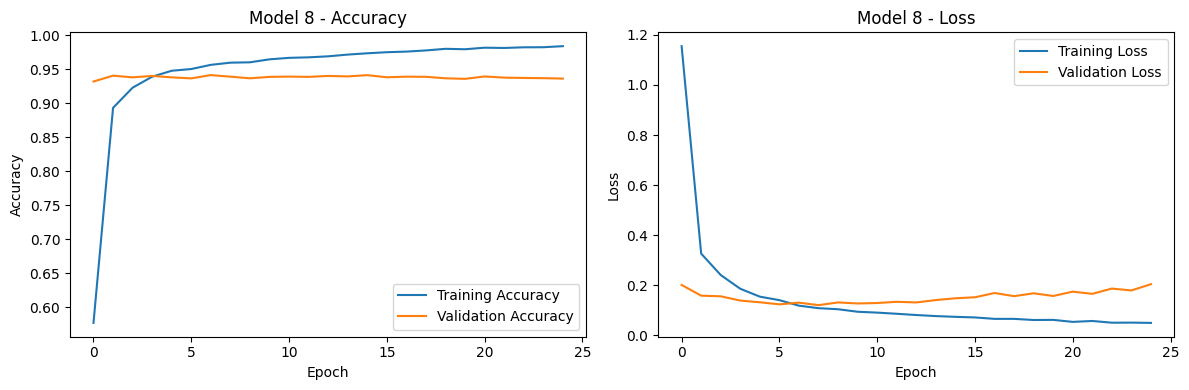

In [33]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_2rows_2cols_6missing_model():
    model_8 = models.Sequential([
        # Input: (36, 10) - 36 positions with 10-class encoding
        layers.Input(shape=(36, 10)),

        # Flatten the input
        layers.Flatten(),  # (36*10 = 360,)

        # Dense layers - more capacity for harder problem
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),

        # Output: 9 classes (digits 1-9)
        layers.Dense(9, activation='softmax')
    ])

    return model_8

# Create and compile model
model_8 = create_2rows_2cols_6missing_model()
model_8.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model_8.summary()

# Train model
print("🔄 Training model_8...")
history = model_8.fit(
    X_train, y_train,
    batch_size=32,
    epochs=25,  # More epochs for harder problem
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate
test_loss, test_acc = model_8.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy: {test_acc:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 8 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model 8 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Test block - Predict 6 missing numbers
import numpy as np

def test_predict_6_missing(model, sudoku_df, num_cases=10):
    """Test model by predicting target intersection from 6 missing numbers"""

    print("🎯 Testing Model 8 - Predict 6 Missing Numbers")
    print("=" * 60)

    correct_predictions = 0

    for case_num in range(num_cases):
        print(f"\nTest Case {case_num + 1}:")
        print("-" * 30)

        # Get random sudoku solution
        solution = sudoku_df['solution'].iloc[case_num]

        # Convert to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Pick random target intersection
        row_idx = np.random.randint(0, 9)
        col_idx = np.random.randint(0, 9)

        # Select other row and column
        other_row = np.random.choice([r for r in range(9) if r != row_idx])
        other_col = np.random.choice([c for c in range(9) if c != col_idx])

        # Get target digit and other intersection digit
        target_digit = grid[row_idx][col_idx]
        other_intersection_digit = grid[other_row][other_col]

        print(f"Target position: Row {row_idx}, Col {col_idx}")
        print(f"Other intersection: Row {other_row}, Col {other_col}")

        # Create 2 rows + 2 columns with 6 missing total

        # Row1: missing target intersection + 1 random
        row1_data = grid[row_idx].copy()
        row1_data[col_idx] = 0  # Hide target intersection
        row1_other_missing = np.random.choice([j for j in range(9) if j != col_idx])
        row1_missing_digit = row1_data[row1_other_missing]
        row1_data[row1_other_missing] = 0

        # Row2: missing other intersection + 1 random
        row2_data = grid[other_row].copy()
        row2_data[other_col] = 0  # Hide other intersection
        row2_other_missing = np.random.choice([j for j in range(9) if j != other_col])
        row2_missing_digit = row2_data[row2_other_missing]
        row2_data[row2_other_missing] = 0

        # Col1: missing target intersection + 1 random
        col1_data = [grid[r][col_idx] for r in range(9)]
        col1_data[row_idx] = 0  # Hide target intersection
        col1_other_missing = np.random.choice([j for j in range(9) if j != row_idx])
        col1_missing_digit = grid[col1_other_missing][col_idx]
        col1_data[col1_other_missing] = 0

        # Col2: missing other intersection + 1 random
        col2_data = [grid[r][other_col] for r in range(9)]
        col2_data[other_row] = 0  # Hide other intersection
        col2_other_missing = np.random.choice([j for j in range(9) if j != other_row])
        col2_missing_digit = grid[col2_other_missing][other_col]
        col2_data[col2_other_missing] = 0

        # Combine to 36 positions
        combined = row1_data + row2_data + col1_data + col2_data
        missing_count = np.sum(np.array(combined) == 0)

        print(f"Row1 with 2 missing:   {row1_data}")
        print(f"Row2 with 2 missing:   {row2_data}")
        print(f"Col1 with 2 missing:   {col1_data}")
        print(f"Col2 with 2 missing:   {col2_data}")
        print(f"Total missing: {missing_count}")

        # Convert to model input format
        X_input = np.zeros((1, 36, 10))
        for j, num in enumerate(combined):
            X_input[0, j, num] = 1

        # Predict target intersection
        prediction = model.predict(X_input, verbose=0)
        predicted_digit = np.argmax(prediction) + 1
        confidence = np.max(prediction) * 100

        # Show results
        print("\n🎯 PREDICTIONS & TRUE VALUES:")
        print(f"Target intersection (True: {target_digit}) → Predicted: {predicted_digit} ({confidence:.1f}%)")

        # Show all 6 missing digits
        print(f"\n📋 ALL 6 MISSING DIGITS:")
        print(f"1. Target intersection: {target_digit}")
        print(f"2. Other intersection: {other_intersection_digit}")
        print(f"3. Row1 other missing: {row1_missing_digit}")
        print(f"4. Row2 other missing: {row2_missing_digit}")
        print(f"5. Col1 other missing: {col1_missing_digit}")
        print(f"6. Col2 other missing: {col2_missing_digit}")

        # Check target prediction
        is_correct = predicted_digit == target_digit
        if is_correct:
            correct_predictions += 1
            print("✅ TARGET PREDICTION CORRECT")
        else:
            print("❌ TARGET PREDICTION WRONG")

        # Show candidate analysis for verification
        print(f"\n🔍 CANDIDATE ANALYSIS:")

        # Row1 candidates (excluding target intersection)
        row1_known = [x for x in row1_data if x != 0]
        row1_candidates = [x for x in range(1, 10) if x not in row1_known]
        print(f"Row1 candidates: {row1_candidates} (should include {target_digit} and {row1_missing_digit})")

        # Col1 candidates (excluding target intersection)
        col1_known = [x for x in col1_data if x != 0]
        col1_candidates = [x for x in range(1, 10) if x not in col1_known]
        print(f"Col1 candidates: {col1_candidates} (should include {target_digit} and {col1_missing_digit})")

    print(f"\n🏆 OVERALL RESULTS:")
    print(f"Correct predictions: {correct_predictions}/{num_cases}")
    print(f"Accuracy: {correct_predictions/num_cases*100:.1f}%")

# Run the test
test_predict_6_missing(model_8, sudoku_games, num_cases=10)

🎯 Testing Model 8 - Predict 6 Missing Numbers

Test Case 1:
------------------------------
Target position: Row 8, Col 2
Other intersection: Row 2, Col 4
Row1 with 2 missing:   [1, 3, 0, 0, 4, 5, 8, 6, 2]
Row2 with 2 missing:   [8, 2, 1, 6, 0, 4, 9, 0, 7]
Col1 with 2 missing:   [9, 3, 1, 0, 8, 6, 5, 2, 0]
Col2 with 2 missing:   [0, 2, 0, 5, 6, 9, 7, 8, 4]
Total missing: 8

🎯 PREDICTIONS & TRUE VALUES:
Target intersection (True: 7) → Predicted: 7 (99.3%)

📋 ALL 6 MISSING DIGITS:
1. Target intersection: 7
2. Other intersection: 3
3. Row1 other missing: 9
4. Row2 other missing: 5
5. Col1 other missing: 4
6. Col2 other missing: 1
✅ TARGET PREDICTION CORRECT

🔍 CANDIDATE ANALYSIS:
Row1 candidates: [7, 9] (should include 7 and 9)
Col1 candidates: [4, 7] (should include 7 and 4)

Test Case 2:
------------------------------
Target position: Row 0, Col 2
Other intersection: Row 2, Col 5
Row1 with 2 missing:   [0, 7, 0, 9, 8, 6, 5, 2, 4]
Row2 with 2 missing:   [5, 9, 2, 4, 7, 0, 8, 0, 1]
Col1 wi

In [35]:
import numpy as np
import random
from sklearn.model_selection import train_test_split

def create_2rows_2cols_6missing_dataset(sudoku_df, max_samples=100000):
    X, y = [], []
    samples_needed = max_samples // 81

    for i, solution in enumerate(sudoku_df['solution']):
        if i >= samples_needed:
            break

        # Convert to 9x9 grid
        grid = []
        for row_start in range(0, 81, 9):
            row = [int(d) for d in solution[row_start:row_start+9]]
            grid.append(row)

        # Generate samples for each position
        for row_idx in range(9):
            for col_idx in range(9):
                # Select 2 rows and 2 columns
                other_row = random.choice([r for r in range(9) if r != row_idx])
                other_col = random.choice([c for c in range(9) if c != col_idx])

                # Store all 6 missing digits
                target_digit = grid[row_idx][col_idx]  # Target intersection
                other_intersection = grid[other_row][other_col]  # Other intersection

                # Create row1 with 2 missing: target intersection + 1 random
                row1_data = grid[row_idx].copy()
                row1_data[col_idx] = 0  # Hide target intersection
                row1_other_missing = random.choice([j for j in range(9) if j != col_idx])
                row1_missing_digit = row1_data[row1_other_missing]
                row1_data[row1_other_missing] = 0

                # Create row2 with 2 missing: other intersection + 1 random
                row2_data = grid[other_row].copy()
                row2_data[other_col] = 0  # Hide other intersection
                row2_other_missing = random.choice([j for j in range(9) if j != other_col])
                row2_missing_digit = row2_data[row2_other_missing]
                row2_data[row2_other_missing] = 0

                # Create col1 with 2 missing: target intersection + 1 random
                col1_data = [grid[r][col_idx] for r in range(9)]
                col1_data[row_idx] = 0  # Hide target intersection
                col1_other_missing = random.choice([j for j in range(9) if j != row_idx])
                col1_missing_digit = grid[col1_other_missing][col_idx]
                col1_data[col1_other_missing] = 0

                # Create col2 with 2 missing: other intersection + 1 random
                col2_data = [grid[r][other_col] for r in range(9)]
                col2_data[other_row] = 0  # Hide other intersection
                col2_other_missing = random.choice([j for j in range(9) if j != other_row])
                col2_missing_digit = grid[col2_other_missing][other_col]
                col2_data[col2_other_missing] = 0

                # Combine: 2 rows + 2 columns = 36 positions
                combined = row1_data + row2_data + col1_data + col2_data

                # Create 6 targets in order
                six_targets = [
                    target_digit,           # Target intersection
                    other_intersection,     # Other intersection
                    row1_missing_digit,     # Row1 other missing
                    row2_missing_digit,     # Row2 other missing
                    col1_missing_digit,     # Col1 other missing
                    col2_missing_digit      # Col2 other missing
                ]

                X.append(combined)
                y.append(six_targets)

    return np.array(X), np.array(y)

# Create dataset
print("🔄 Creating 2 rows + 2 columns with 6 targets dataset...")
X, y = create_2rows_2cols_6missing_dataset(sudoku_games, max_samples=50000)
print(f"Dataset shape: X={X.shape}, y={y.shape}")

# Count missing elements per sample
missing_counts = [np.sum(sample == 0) for sample in X]
print(f"Missing elements per sample: {set(missing_counts)}")

# Sparse encode inputs (36 positions, 10 classes each: 0-9)
X_sparse = np.zeros((len(X), 36, 10))
for i, sample in enumerate(X):
    for j, num in enumerate(sample):
        X_sparse[i, j, num] = 1

# One-hot encode 6 targets
y_onehot = np.zeros((len(y), 6, 9))  # 6 targets, 9 classes each
for i, targets in enumerate(y):
    for j, target in enumerate(targets):
        y_onehot[i, j, target - 1] = 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y_onehot, test_size=0.2, random_state=42
)

print(f"✅ Training: X={X_train.shape}, y={y_train.shape}")
print(f"✅ Test: X={X_test.shape}, y={y_test.shape}")
print("✅ 2 rows + 2 columns with 6 targets (36 positions) ready!")

🔄 Creating 2 rows + 2 columns with 6 targets dataset...
Dataset shape: X=(49977, 36), y=(49977, 6)
Missing elements per sample: {np.int64(8)}
✅ Training: X=(39981, 36, 10), y=(39981, 6, 9)
✅ Test: X=(9996, 36, 10), y=(9996, 6, 9)
✅ 2 rows + 2 columns with 6 targets (36 positions) ready!


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)            │ (None, 360)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 512)            │       184,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 54)             │         6,966 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 6, 9)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,022 (1.36 MB)

 Trainable params: 356,022 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

🔄 Training model_8 for 6 targets...
Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 2.0266 - multi_target_accuracy: 0.2122 - val_loss: 0.8869 - val_multi_target_accuracy: 0.6911
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.0409 - multi_target_accuracy: 0.6164 - val_loss: 0.3473 - val_multi_target_accuracy: 0.9021
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6776 - multi_target_accuracy: 0.7563 - val_loss: 0.2166 - val_multi_target_accuracy: 0.9307
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.5253 - multi_target_accuracy: 0.8125 - val_loss: 0.1606 - val_multi_target_accuracy: 0.9349
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4447 - multi_target_accuracy: 0.8404 - val_loss: 0.1378 - val_multi_target_accuracy: 0.9365
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.3981 - multi_target_accuracy: 0.8541 - val_loss: 0.1241 - val_multi_target_accuracy: 0.9373
Epoch 7/30
1250/1250 ━━━━━━

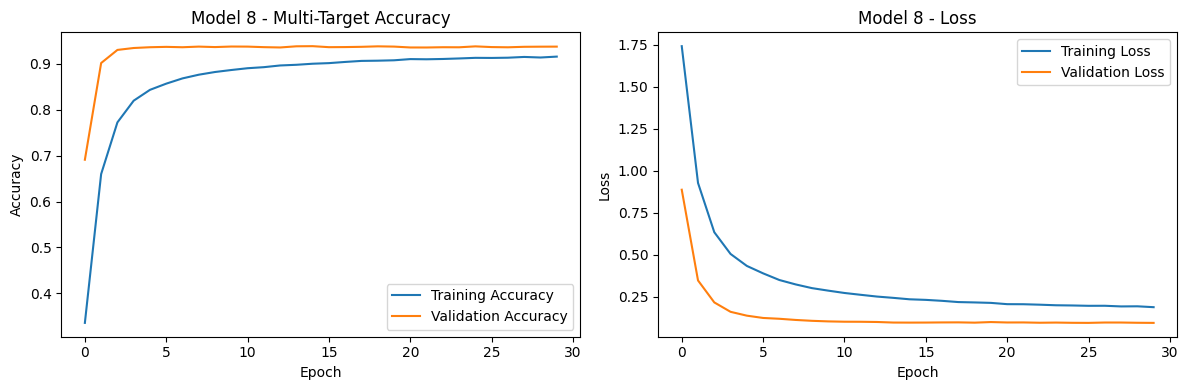

In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_2rows_2cols_6targets_model():
    model_9 = models.Sequential([
        # Input: (36, 10) - 36 positions with 10-class encoding
        layers.Input(shape=(36, 10)),

        # Flatten the input
        layers.Flatten(),  # (36*10 = 360,)

        # Dense layers - more capacity for predicting 6 numbers
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),

        # Output: 6 targets × 9 classes = 54 outputs
        layers.Dense(54, activation='softmax'),

        # Reshape to (6, 9) - 6 predictions of 9 classes each
        layers.Reshape((6, 9))
    ])

    return model_9

# Create and compile model
model_9 = create_2rows_2cols_6targets_model()

# Custom loss for multi-target prediction
def multi_target_categorical_crossentropy(y_true, y_pred):
    # y_true shape: (batch_size, 6, 9)
    # y_pred shape: (batch_size, 6, 9)
    loss = 0
    for i in range(6):
        loss += tf.keras.losses.categorical_crossentropy(y_true[:, i, :], y_pred[:, i, :])
    return loss / 6

# Custom accuracy for multi-target prediction
def multi_target_accuracy(y_true, y_pred):
    # Calculate accuracy for each of the 6 targets
    accuracies = []
    for i in range(6):
        pred_class = tf.argmax(y_pred[:, i, :], axis=1)
        true_class = tf.argmax(y_true[:, i, :], axis=1)
        acc = tf.reduce_mean(tf.cast(tf.equal(pred_class, true_class), tf.float32))
        accuracies.append(acc)
    return tf.reduce_mean(accuracies)

model_9.compile(
    optimizer='adam',
    loss=multi_target_categorical_crossentropy,
    metrics=[multi_target_accuracy]
)

# Model summary
model_9.summary()

# Train model
print("🔄 Training model_8 for 6 targets...")
history = model_9.fit(
    X_train, y_train,
    batch_size=32,
    epochs=30,  # More epochs for harder 6-target problem
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate
test_loss, test_acc = model_9.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test Accuracy (Average of 6 targets): {test_acc:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['multi_target_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_multi_target_accuracy'], label='Validation Accuracy')
plt.title('Model 8 - Multi-Target Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model 8 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
# Test model with 10 cases
import numpy as np

def test_model_10_cases(model, X_test, y_test):
    """Test model with 10 random cases and display results"""

    # Select 10 random test cases
    test_indices = np.random.choice(len(X_test), 10, replace=False)

    print("🧪 Testing Model with 10 Cases")
    print("=" * 50)

    total_correct = 0
    total_predictions = 0

    for i, idx in enumerate(test_indices, 1):
        # Get single test case
        x_single = X_test[idx:idx+1]  # Shape: (1, 36, 10)
        y_true = y_test[idx]          # Shape: (6, 9)

        # Make prediction
        y_pred = model.predict(x_single, verbose=0)[0]  # Shape: (6, 9)

        # Convert to class predictions
        true_classes = np.argmax(y_true, axis=1) + 1  # Convert back to 1-9
        pred_classes = np.argmax(y_pred, axis=1) + 1  # Convert back to 1-9

        # Calculate accuracy for this case
        correct = np.sum(true_classes == pred_classes)
        case_accuracy = correct / 6

        total_correct += correct
        total_predictions += 6

        print(f"Case {i:2d}:")
        print(f"  True: {true_classes}")
        print(f"  Pred: {pred_classes}")
        print(f"  Accuracy: {correct}/6 ({case_accuracy:.1%})")
        print()

    # Overall accuracy
    overall_accuracy = total_correct / total_predictions
    print("=" * 50)
    print(f"📊 OVERALL RESULTS:")
    print(f"   Correct: {total_correct}/{total_predictions}")
    print(f"   Accuracy: {overall_accuracy:.1%}")
    print("=" * 50)

    return overall_accuracy

# Run the test
accuracy = test_model_10_cases(model_9, X_test, y_test)

🧪 Testing Model with 10 Cases
Case  1:
  True: [3 9 1 5 6 7]
  Pred: [3 9 1 5 6 7]
  Accuracy: 6/6 (100.0%)

Case  2:
  True: [7 4 3 8 8 8]
  Pred: [7 4 3 8 8 8]
  Accuracy: 6/6 (100.0%)

Case  3:
  True: [9 1 3 8 4 4]
  Pred: [9 1 3 8 4 4]
  Accuracy: 6/6 (100.0%)

Case  4:
  True: [6 6 4 8 2 7]
  Pred: [6 6 4 8 2 7]
  Accuracy: 6/6 (100.0%)

Case  5:
  True: [3 7 5 8 1 2]
  Pred: [3 7 5 8 1 2]
  Accuracy: 6/6 (100.0%)

Case  6:
  True: [3 5 2 3 7 3]
  Pred: [3 5 2 5 7 3]
  Accuracy: 5/6 (83.3%)

Case  7:
  True: [7 4 6 1 4 9]
  Pred: [7 4 6 1 4 9]
  Accuracy: 6/6 (100.0%)

Case  8:
  True: [6 5 5 2 9 1]
  Pred: [6 5 5 2 9 1]
  Accuracy: 6/6 (100.0%)

Case  9:
  True: [1 4 6 7 8 9]
  Pred: [1 4 6 7 8 9]
  Accuracy: 6/6 (100.0%)

Case 10:
  True: [7 9 2 7 8 4]
  Pred: [7 9 2 7 8 4]
  Accuracy: 6/6 (100.0%)

📊 OVERALL RESULTS:
   Correct: 59/60
   Accuracy: 98.3%
